In this worked example we will be going through how to obatin the best model possible as well as how we can convince ourselves that we have the best model we can obtain. We expect that you already have a basic understanding of the modeling we are trying to do, that you are familiar with most python tools used and that you have gone through and read the script. Therefore no detailed explenation of how the code works will be given in the text cells. 

This process requieres a fair about of trial and error so do not be too worried if your first fit does not give you a convincing model.

The first step is importing all the functions we will use in the script

In [13]:
'''
We first import all the functions we will need. Make sure to run this first.
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
from lmfit import Model, Parameters, minimize
import scipy.ndimage
import copy
from scipy.ndimage.filters import gaussian_filter
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from reproject import reproject_exact
from scipy.stats import norm
import matplotlib.colors as colors

When selecting the region over which we are trying to fit we need to be very careful about a number of things:
- Mae sure to have an area large enough so that the background column density can be accurately estimated. It is tempting to restrain the area we are looking at to the condenstions we are trying to model. At best, this can lead to an underestimation of the background number density and yield innacurate magnetic field stength values. At worst, the model will settle on a solution with a 0 or negative background density.
- Make sure that only the condensations we are interested in are present. If more than 3 condensations are present the model will try and fit themall with just 3 condensations which will most likely result in a non physical solution. If you need to have an unwanted condensation in the frame in order to have a box large enough to estimate the background we recommend that you mask out this condensation and replace it with nan values. 
- When choosing the depth of the material that we are looking through, the recommended way to estimate it is to look at a map of the region in which the condensation is and to find how far the nearest condensations are. Half that distance is the number we recommend using for the depth.

In the example bellow we have chosen an area which is too small. While we are only looking at the condensation we are missing a large quantity of the background.
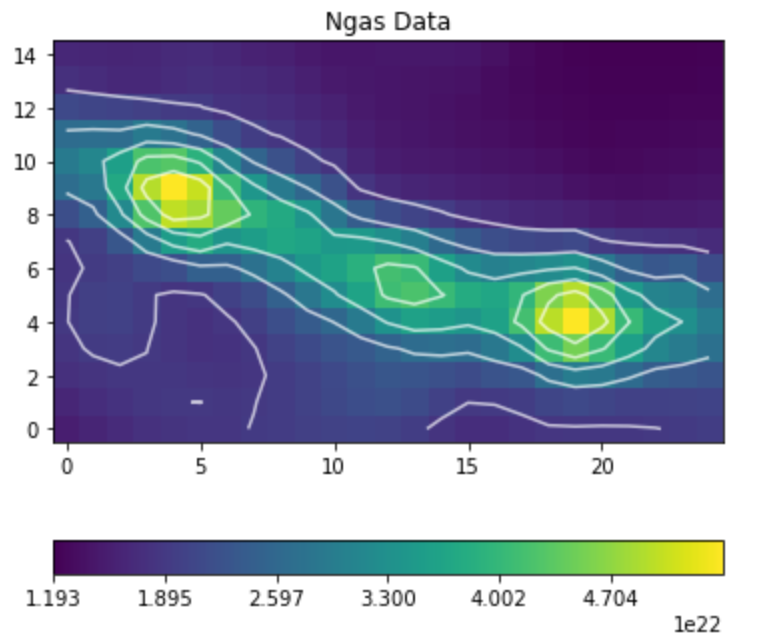

The next example has an image that is too extended and has other condensations present which will reduce the accuracy of the model.
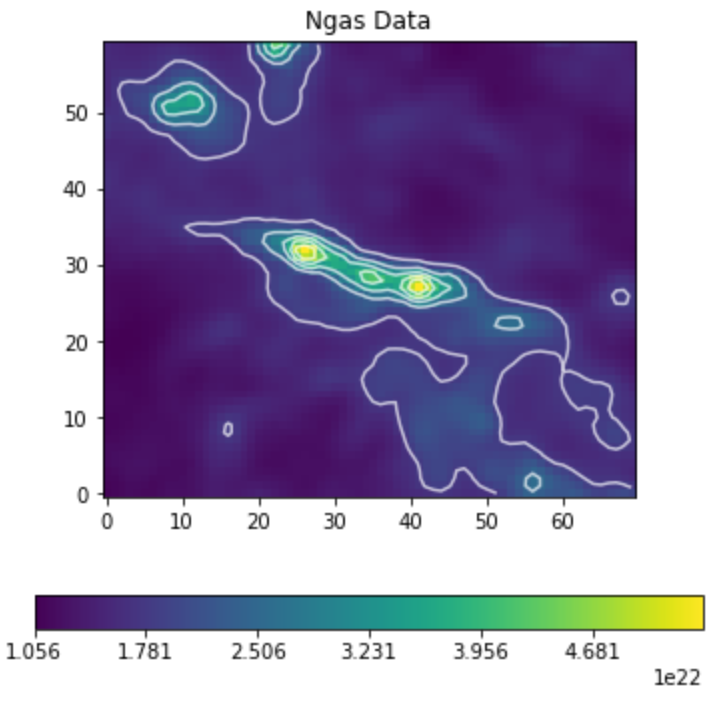

The next one is looking over an area that has enough background and does not have any extra condensations.
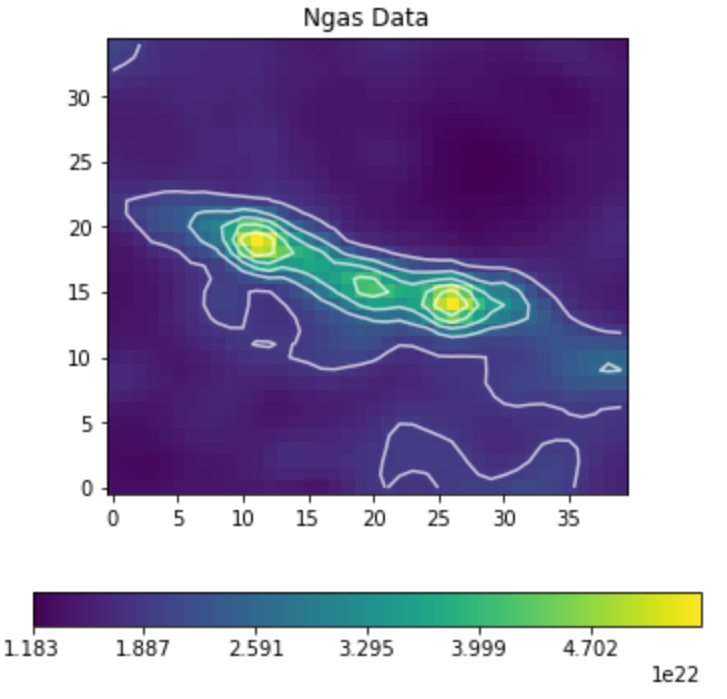

min =  1.183126065556977e+22 , max =  5.406206314648678e+22
Contour levels =  [1.18312607e+22 1.88697277e+22 2.59081948e+22 3.29466619e+22
 3.99851290e+22 4.70235961e+22]


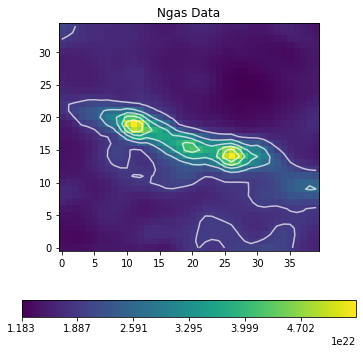

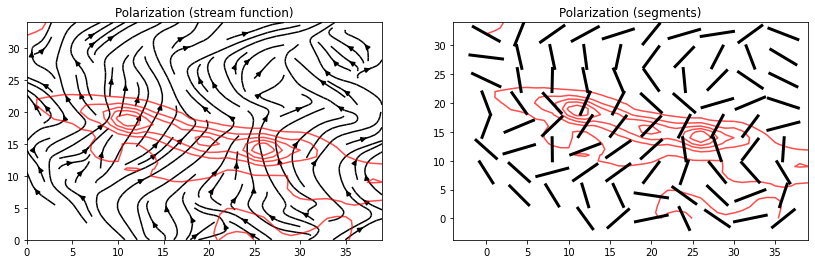

In [23]:
'''
This is where we first make a cut out of the region of interest and look at the polarisation data. Here are a few things to do before we start:
- Make sure that everything is on the same grid, that the polaristion angle is going counter clockwise from north,
    that all the necessary analysis is applied to the PA data beofre starting the process
- Do not forget the velocity dispersion data in km/s and PA data in degrees
- I recommend to do all the work here in its own directory

This process will require some tweaking so make sure that you read every comment so that you can use the scripts to their best potential and 
make your own edits if needed. Good luck!!
'''

#First we set a few constants that we will use. 

#This is the depth of at which we are looking. (2*z in the model) this value is in pixels Make sure that it is large enough but not too big
depth = 60

xcenter=18.628 #location of the x value of the centre of the image (degrees)
ycenter=-0.065 #location of the y value of the centre of the image (degrees)
coords = SkyCoord(l=xcenter*u.degree, b=ycenter*u.degree, frame='galactic', unit= (u.deg) ) #This is for galactic coordinates.
#If using FK5 change it to: SkyCoord(ra=xcenter*u.degree, dec=ycenter*u.degree, frame='FK5', unit= (u.deg) )

width= 40 # width of the image (pixels)
height= 35 # height of the image (pixels)

num_of_contours = 6 # This is the number of contour levels we want to use when we display the Ngas contours

step = 4 # This determines how many vectors we display if we set it to 1 we display every pixel, 2 we display every 2nd pixel etc...
scale = step # This is the size length of each vector displayed. We recommend to keep it equal to step

distance = 3400 #This is the distance to the object in pc
pc_in_deg = np.degrees(1/distance) #This is the size of one pc at the given distance in degrees
deg_per_pix = 0.003194444 #This is the size of each pixel in degrees (information should be in the header)
pc_in_cm = 3.086e+18 #This is the conversion factor from pc to cm
pix_in_pc = deg_per_pix/pc_in_deg #This calculates how many pc each pixel represents
pix_in_cm = pc_in_cm*deg_per_pix/pc_in_deg #This calculates how many centimeters each pixel represents

#This is the radius of the filamentary structure that we are looking at in pc. This is only relevant if you are looking at a system that is inbeded in a 
# filamentary structure and want to estimate the density from the data instead of the model. We use this method to estimate mean B-fields in 
# Stephens 2022
filament_radius_pc = 1.1 

#This is where you put the location of the relevant files
column_density_file = '/home/jessym/harvard/fil_5/fits/HIGAL_L_Fil5_Ngas.fits'
BAngle_file = '/home/jessym/harvard/fil_5/fits/Fil5_BAngle_reprojectGal.fits'
widths_file = 'Galregrid_13CO_cube_single_width.fits'

#This is if you do not have all the data on the same grid. We use reproject.reproject_exact() in order to reproject the PA and velocity dispersion maps.
#This does not do a rigourous conversion of the PA based on the Q and U components so it should not be used to obtain your final data products.
same_grid = False 

#This marks the end of the needed user inputs for this section-------------------------------------------------------------------------------------

pc_in_deg = np.degrees(1/distance) #This is the size of one pc at the given distance in degrees
pc_in_cm = 3.086e+18 #This is the conversion factor from pc to cm
cm_in_au = 1.49598073e+13 #This is the conversion factor from AU to cm
pix_in_pc = deg_per_pix/pc_in_deg #This calculates how many pc each pixel represents
pix_in_cm = pc_in_cm*deg_per_pix/pc_in_deg #This calculates how many centimeters each pixel represents
#This is the mean molecular weight of H2. If your column density is not the H2 column density you will need to change this number
mean_molecular_weight = 2.37 
mu_times_mp = mean_molecular_weight*1.68571016E-24 #This calculates the mass of each particle in grams
pixel_size_arcsec = deg_per_pix*3600 #This is the size of each pixel in arcsecs
filament_radius_cm = filament_radius_pc*pc_in_cm #Radius of filament in cm
R = filament_radius_cm 

column_fits = fits.open(column_density_file)[0]
column_data = column_fits.data
column_header = column_fits.header
column_world = WCS(column_header)
column_centre = column_world.world_to_pixel(coords) #We find the pixel location of the coordinates given

BAngle_fits = fits.open(BAngle_file)[0]
BAngle_data = BAngle_fits.data

widths_fits = fits.open(widths_file)[0]
widths_data = widths_fits.data

#Making cut outs of the given maps
if same_grid:
    widths_cut = Cutout2D(widths_data, column_centre, (height, width)).data
    BAngle_data_cut = Cutout2D(BAngle_data, column_centre, (height, width)).data
else:
    widths_reproj = reproject_exact(widths_fits, column_header, return_footprint = False)
    widths_cut = Cutout2D(widths_reproj, column_centre, (height, width)).data
    B_reproj = reproject_exact(BAngle_fits, column_header, return_footprint = False)
    BAngle_data_cut = Cutout2D(B_reproj, column_centre, (height, width)).data
    
data = Cutout2D(column_data, column_centre, (height, width)).data

#Setting up the contours
contour_levels = np.arange(np.nanmin(data), np.nanmax(data), (np.nanmax(data)-np.nanmin(data))/num_of_contours)
print('min = ',np.min(data),', max = ', np.max(data))
print('Contour levels = ', contour_levels)

#Plotting the column density data
Bdir_x = -np.sin(np.radians(np.array(BAngle_data_cut)))
Bdir_y = np.cos(np.radians(np.array(BAngle_data_cut)))
plt.figure(figsize=(6,6))
plt.title('Ngas Data')
plt.imshow(data, origin='lower')
plt.colorbar(location='bottom', ticks = contour_levels)
plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
#plt.savefig('Ngas_data.pdf')
plt.show()

#Plotting the B-field direction
x = np.arange(0,np.shape(BAngle_data_cut)[1],1)
y = np.arange(0,np.shape(BAngle_data_cut)[0],1)
xarr, yarr = np.meshgrid(x,y)
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='k')
plt.contour(data, levels=contour_levels, colors = 'r', alpha = 0.7)
plt.title('Polarization (stream function)')
plt.subplot(1,2,2)
plt.contour(data, levels=contour_levels, colors = 'r', alpha = 0.7)
data_angle = np.radians(BAngle_data_cut)
(ys,xs) = data_angle.shape
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'k',  linewidth=3) 

plt.title('Polarization (segments)')
#plt.savefig('Data_polarisation_maps.pdf')
plt.show()

#Normalisong the data for the next steps
med = np.median(data)
norm_data = data/med
norm_contour_levels = contour_levels/med

Next we make the density model. This step is the most finicky so here is how to make it easier. 

The first thing we want to do is locate where the centre of each condensation is. To do this, we first force the model to fit spherical condensations to the data. This will give you the central position of the condensations as well as an idea of what inital value to put in for the scale lengths. To do this step we need to fix the aspect ratio to being 1 and the angle to be 0. We also want give initial guesses for the position that are more or less where we think they might be. 

Note that the model might return values for the background density or peak density that do not make sense. This is okay for now as we are only interested in the pixel location of the centres.

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1               1        1        5        0    False     None     None
A_2               1        1       10        0    False     None     None
A_3               1        1        5        0    False     None     None
n_0_1         1.721        0      inf    0.389     True     None     None
n_0_2         25.52        0      inf    258.2     True     None     None
n_0_3         1.352        0      inf   0.2738     True     None     None
n_u         0.01208    1e-06      inf 0.0001741     True     None     None
r_0_1        0.6398        0      inf  0.08228     True     None     None
r_0_2        0.1109        0      inf    0.569     True     None     None
r_0_3        0.7202        0      inf  0.08558     True     None     None
theta_1           0   -1.571    1.571        0    False     None     None
theta_2           0   -1.571    1.571        0    False     None     None
theta_3           0   -1.571    1.5

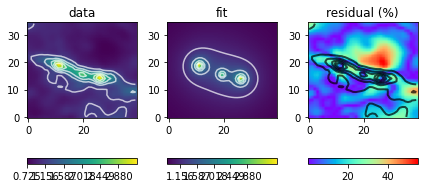

Nu =  1.1839035790384582e+22  [cm^-2]
N01 =  1.6859253388645575e+24  [cm^-2]
N02 =  2.5006793150950356e+25  [cm^-2]
N03 =  1.3249903644148815e+24  [cm^-2]
nu =  337.3009757800406  [cm^-3]
n01 =  48032.9878175694  [cm^-3]
n02 =  712457.9974490636  [cm^-3]
n03 =  37749.74167907074  [cm^-3]
r01 =  0.12128191901251849  [pc]
r02 =  0.02101567128796902  [pc]
r03 =  0.1365212571330586  [pc]


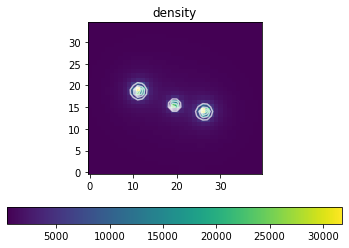

In [24]:
'''
This section is where we find the best fit model to the data.

This model attempts to fit a total of 19 parameters so there is potential for a LOT of degeneracy. We thus need to be careful and make sure that we can
be confident about the results we are getting.
When adding the parameters there are a number of things we can do to reduce the time needed to obtain a fit as well as obtaining a better, 
more accurate fit. Each parameter needs to be set and given an initial value. 
There are a number of limiters we can put on the data the most relevant are:
    - set a maximum and minimum value with max = and min = . This is recomended as it reduces the risk of the model setteling on a non physical solution
    and reduces the time needed to find a best fit.
    - fix the value of the parameter by setting vary = False. It is to true by default.
        - This is useful if you already know the pixel location of the condensations or know that they are spherical etc...
    - set the relation between parameters by setting expr = ''. Let's set the parameters n_0_1 and n_0_2 where we want n_0_2 < n_0_1. This is easily 
    done by adding a new parameter that we'll call 'factor':
    
    params.add('n_0_1', value=np.max(norm_data), min=0)
    params.add(name="factor", value = 0.5, min=0, max=1)
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1 * factor')

    This ensures that n_0_2 < n_0_1. 

    To have them be equal we can simply write:
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1')
    
    We encourage you to visit this link for more information: https://lmfit.github.io/lmfit-py/parameters.html
'''
#Set a Paramaters instance and add all the necessary parameters, their initial guess and limits
params = Parameters() 
params.add('n_0_1', value=np.max(norm_data), min=0)
#params.add(name="factor", value = 0.5, min=0, max=0.9)
params.add('n_0_2', value=np.max(norm_data), min=0) #, expr='n_0_1 * factor'
params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1.278, min=0.)
params.add('r_0_2', value=1.116, min=0.)
params.add('r_0_3', value=1.141, min=0.)
params.add('n_u', value=np.min(norm_data), min=0.000001)
params.add('A_1', value=1., min = 1.0, max = 5, vary = False)
params.add('A_2', value=1., min = 1.0, max = 10, vary = False)
params.add('A_3', value=1., min = 1.0, max = 5, vary = False)
params.add('theta_1', value=0, min = -np.pi/2, max = np.pi/2, vary = False)
params.add('theta_2', value=0, min = -np.pi/2, max = np.pi/2, vary = False)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2, vary = False)
params.add('xcentre_1', value=12  , min = 0, vary = True)
params.add('ycentre_1', value=18  , min = 0, vary = True)
params.add('xcentre_2', value=20, min = 0, max = 36, vary = True)
params.add('ycentre_2', value=15, min = 0, max = 30, vary = True)
params.add('xcentre_3', value=27 , min = 0, vary = True)
params.add('ycentre_3', value= 13, min = 0, vary = True)

def fitting(mesh,n_0_1, n_0_2, n_0_3 ,r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    '''
    This is the function that we use to fit the column density. We follow the same methodology as Myers, 2020. 
    
    The function needs the grid over which the model is calculated, the peak number density (n_0), scale length (r_0), aspect ratio (A), 
    incination on the plane of the sky (theta), x and y position for each condensation (xcentre, ycentre) and the background number density
    (or innitial state) number density (n_u). 
    
    We also use the depth through which we are looking though it is not requiered to be given in the function as it is not relevant to the fitting
    
    The function outputs the model in the form of a 2-D numpy array which can be easily displayed using plt.imshow()
    '''
    z = depth/2 #Setting z in the model
    
    #We itterate over every pixel of the mesh and calculate and add together the contribution from each condensation at that location
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            #Changing the x and y coordinates to be wrt the centre of the condensation with the x-axis being along its long axis
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1) 
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1) 
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1 #This is where we calculate the contribution of the condensation at that location
            
            #Now we do the same process for the other two condensations
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2
            
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3
            
            mesh[y,x] = part_1+part_2+part_3+2*z*n_u #We add the contributions together and add the effect of the background
            
    return np.array(mesh)

#Making the grid we will use for the model
grid = np.zeros([height, width])

lmfit_model_pro_per = Model(fitting) #Setting the Model instance and defining the model with the function

'''
The command bellow does the fitting. The fitting algorythm uses the standard Levenberg-Marquardt algorithm. There are a number of limitations with that
method so if you wish to use another one you can simply add method = ''. See 
https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods for information on what methods are available.

If you have NaN values in the data you are trying to fit you need to make sure to add nan_policy='omit' or the fitting will give an error
'''
result = lmfit_model_pro_per.fit(norm_data, #the data we are fitting
                               mesh = grid, #the grid we are using for our fit
                               params = params) #the parameters we defined above

#Printing the values of each parameter and their error in a neat way. If you need more information you can uncomment the line bellow
#Note that the number densities and scale lengths printed are in normalised, and pixel units. The true value is printed later in the script.
result.params.pretty_print() 
#print(result.fit_report())

fit =  result.best_fit #Extracting the best fit 

residual = abs((fit - norm_data)/norm_data) #calculating the residuals

#Plotting the results
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
plt.colorbar(ticks = norm_contour_levels, orientation='horizontal') # location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.colorbar(ticks = norm_contour_levels, location = 'bottom')
plt.contour(fit, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual*100, origin='lower', cmap='rainbow')
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.tight_layout()
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

#extracting the parameters 
n01, n02, n03, r01, r02, r03, nu, A1, A2, A3, theta1, theta2, theta3, x1, y1, x2, y2, x3, y3 = result.params['n_0_1'].value,\
    result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, result.params['r_0_2'].value,result.params['r_0_3'].value,\
    result.params['n_u'].value, result.params['A_1'].value, result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value,\
    result.params['theta_2'].value, result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, \
    result.params['xcentre_2'].value,result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value

#Convert the values to propper units
nu = nu*med/pix_in_cm
n01 = n01*med/pix_in_cm
n02 = n02*med/pix_in_cm
n03 = n03*med/pix_in_cm
print('Nu = ', result.params['n_u'].value*med*depth, ' [cm^-2]')
print('N01 = ', result.params['n_0_1'].value*med*depth, ' [cm^-2]')
print('N02 = ', result.params['n_0_2'].value*med*depth, ' [cm^-2]')
print('N03 = ', result.params['n_0_3'].value*med*depth, ' [cm^-2]')
print('nu = ', nu, ' [cm^-3]')
print('n01 = ', n01, ' [cm^-3]')
print('n02 = ', n02, ' [cm^-3]')
print('n03 = ', n03, ' [cm^-3]')
print('r01 = ', r01*pix_in_pc, ' [pc]')
print('r02 = ', r02*pix_in_pc, ' [pc]')
print('r03 = ', r03*pix_in_pc, ' [pc]')

#Then we calculate the number density of the model at z = 0
def rho(mesh):
    '''
    This function calculates the number density of the gas at each pixel
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            part_1 = n01/frac_1
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            part_2 = n02/frac_2
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            part_3 = n03/frac_3
            mesh[y,x] = part_1+part_2+part_3+nu
            
            
    return np.array(mesh)
#Plotting and saving the figure
density = rho(grid)
density_contour_levels = np.arange(np.nanmin(density), np.nanmax(density), (np.nanmax(density)-np.nanmin(density))/num_of_contours)
plt.title('density')
plt.imshow(density, origin='lower')
plt.colorbar(location='bottom')
plt.contour(density, levels=density_contour_levels, colors = 'white', alpha = 0.7)
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

Once we have the x and y coordinates of the centers we can copy them into the inital guesses again and fix them in place. Set the inital values of the aspect ratios at 1.1 and let them and the angles vary. 

At this point you might still be getting numbers for the background number density/column density that you do not think are right or the fit isn't quite right. There are a few solutions that we can put in place if that is the case:
- The first thing we recommend is to allow the values of the centre to vary but restrain them to +/- 2 pixels from the guess the model gives when fitting spherical condensations. The exact location might not be right and lead the model to settle on an innacurate solution.
- If you have a good idea of the inclination of the condensations then limit the 
- The model might still have too many parameters. If two condensations seem to have a similar size or similar peak column densities then setting them to be equal has fixed this sort of issue in the past. In general, it is recommended that you limit the number of variables as much as you can when doing the fit.
- If the background is still an issue you will need to fix it to a value that you chose. Using a tool like DS9 do a few cross cuts through the map and estimate what the background column density is. Then set the value (for example 1e22) of nu in the model to nu =  1e22/(med*depth). This is the least preferable option but like this we can at least continue with the modeling of the field lines. It is important to remember that this might not be possible to do for every data set that you are trying to fit. If you are still having problems then feel free to reach out to us and we can discuss a possible path forward.

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1           3.794        1        5   0.3162     True     None     None
A_2           7.728        1       10   0.8471     True     None     None
A_3           3.142        1        5   0.3329     True     None     None
n_0_1         1.588        0      inf      0.3     True     None     None
n_0_2        0.8329        0      inf   0.2098     True     None     None
n_0_3         2.607        0      inf    1.164     True     None     None
n_u         0.01286    1e-06      inf 0.0001289     True     None     None
r_0_1          0.45        0      inf  0.05464     True     None     None
r_0_2        0.4572        0      inf  0.08909     True     None     None
r_0_3        0.3044        0      inf  0.07965     True     None     None
theta_1     -0.4287   -1.571    1.571  0.01863     True     None     None
theta_2     -0.3057   -1.571    1.571   0.0178     True     None     None
theta_3     -0.1589   -1.571    1.5

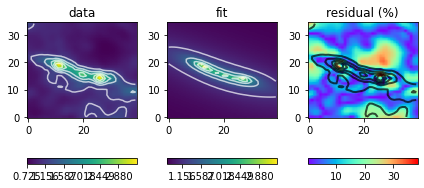

Nu =  1.2600064014414151e+22  [cm^-2]
N01 =  1.5563424265320494e+24  [cm^-2]
N02 =  8.16077579667654e+23  [cm^-2]
N03 =  2.5546428135399596e+24  [cm^-2]
nu =  358.9831099593973  [cm^-3]
n01 =  44341.09571182263  [cm^-3]
n02 =  23250.522154656966  [cm^-3]
n03 =  72783.25102085914  [cm^-3]
r01 =  0.08529852612159362  [pc]
r02 =  0.08667230544749813  [pc]
r03 =  0.05770055243258866  [pc]


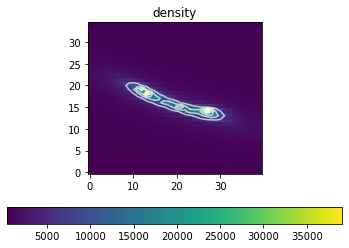

In [25]:
'''
This section is where we find the best fit model to the data.

This model attempts to fit a total of 19 parameters so there is potential for a LOT of degeneracy. We thus need to be careful and make sure that we can
be confident about the results we are getting.
When adding the parameters there are a number of things we can do to reduce the time needed to obtain a fit as well as obtaining a better, 
more accurate fit. Each parameter needs to be set and given an initial value. 
There are a number of limiters we can put on the data the most relevant are:
    - set a maximum and minimum value with max = and min = . This is recomended as it reduces the risk of the model setteling on a non physical solution
    and reduces the time needed to find a best fit.
    - fix the value of the parameter by setting vary = False. It is to true by default.
        - This is useful if you already know the pixel location of the condensations or know that they are spherical etc...
    - set the relation between parameters by setting expr = ''. Let's set the parameters n_0_1 and n_0_2 where we want n_0_2 < n_0_1. This is easily 
    done by adding a new parameter that we'll call 'factor':
    
    params.add('n_0_1', value=np.max(norm_data), min=0)
    params.add(name="factor", value = 0.5, min=0, max=1)
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1 * factor')

    This ensures that n_0_2 < n_0_1. 

    To have them be equal we can simply write:
    params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1')
    
    We encourage you to visit this link for more information: https://lmfit.github.io/lmfit-py/parameters.html
'''
#Set a Paramaters instance and add all the necessary parameters, their initial guess and limits
params = Parameters() 
params.add('n_0_1', value=np.max(norm_data), min=0)
#params.add(name="factor", value = 0.5, min=0, max=0.9)
params.add('n_0_2', value=np.max(norm_data), min=0) #, expr='n_0_1 * factor'
params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1.278, min=0.)
params.add('r_0_2', value=1.116, min=0.)
params.add('r_0_3', value=1.141, min=0.)
params.add('n_u', value=np.min(norm_data), min=0.000001)
params.add('A_1', value=1.1, min = 1.0, max = 5, vary = True)
params.add('A_2', value=1.1, min = 1.0, max = 10, vary = True)
params.add('A_3', value=1.1, min = 1.0, max = 5, vary = True)
params.add('theta_1', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('theta_2', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2, vary = True)
params.add('xcentre_1', value=12.58  , min = 0, vary = False)
params.add('ycentre_1', value=18.4  , min = 0, vary = False)
params.add('xcentre_2', value=20.53 , min = 0, max = 36, vary = False)
params.add('ycentre_2', value=15.02, min = 0, max = 30, vary = False)
params.add('xcentre_3', value=27.51 , min = 0, vary = False)
params.add('ycentre_3', value= 13.66, min = 0, vary = False)

def fitting(mesh,n_0_1, n_0_2, n_0_3 ,r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    '''
    This is the function that we use to fit the column density. We follow the same methodology as Myers, 2020. 
    
    The function needs the grid over which the model is calculated, the peak number density (n_0), scale length (r_0), aspect ratio (A), 
    incination on the plane of the sky (theta), x and y position for each condensation (xcentre, ycentre) and the background number density
    (or innitial state) number density (n_u). 
    
    We also use the depth through which we are looking though it is not requiered to be given in the function as it is not relevant to the fitting
    
    The function outputs the model in the form of a 2-D numpy array which can be easily displayed using plt.imshow()
    '''
    z = depth/2 #Setting z in the model
    
    #We itterate over every pixel of the mesh and calculate and add together the contribution from each condensation at that location
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            #Changing the x and y coordinates to be wrt the centre of the condensation with the x-axis being along its long axis
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1) 
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1) 
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1 #This is where we calculate the contribution of the condensation at that location
            
            #Now we do the same process for the other two condensations
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2
            
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3
            
            mesh[y,x] = part_1+part_2+part_3+2*z*n_u #We add the contributions together and add the effect of the background
            
    return np.array(mesh)

#Making the grid we will use for the model
grid = np.zeros([height, width])

lmfit_model_pro_per = Model(fitting) #Setting the Model instance and defining the model with the function

'''
The command bellow does the fitting. The fitting algorythm uses the standard Levenberg-Marquardt algorithm. There are a number of limitations with that
method so if you wish to use another one you can simply add method = ''. See 
https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods for information on what methods are available.

If you have NaN values in the data you are trying to fit you need to make sure to add nan_policy='omit' or the fitting will give an error
'''
result = lmfit_model_pro_per.fit(norm_data, #the data we are fitting
                               mesh = grid, #the grid we are using for our fit
                               params = params) #the parameters we defined above

#Printing the values of each parameter and their error in a neat way. If you need more information you can uncomment the line bellow
#Note that the number densities and scale lengths printed are in normalised, and pixel units. The true value is printed later in the script.
result.params.pretty_print() 
#print(result.fit_report())

fit =  result.best_fit #Extracting the best fit 

residual = abs((fit - norm_data)/norm_data) #calculating the residuals

#Plotting the results
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
plt.colorbar(ticks = norm_contour_levels, orientation='horizontal') # location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.colorbar(ticks = norm_contour_levels, location = 'bottom')
plt.contour(fit, levels=norm_contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual*100, origin='lower', cmap='rainbow')
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.contour(norm_data, levels=norm_contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.tight_layout()
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

#extracting the parameters 
n01, n02, n03, r01, r02, r03, nu, A1, A2, A3, theta1, theta2, theta3, x1, y1, x2, y2, x3, y3 = result.params['n_0_1'].value,\
    result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, result.params['r_0_2'].value,result.params['r_0_3'].value,\
    result.params['n_u'].value, result.params['A_1'].value, result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value,\
    result.params['theta_2'].value, result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, \
    result.params['xcentre_2'].value,result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value

#Convert the values to propper units
nu = nu*med/pix_in_cm
n01 = n01*med/pix_in_cm
n02 = n02*med/pix_in_cm
n03 = n03*med/pix_in_cm
print('Nu = ', result.params['n_u'].value*med*depth, ' [cm^-2]')
print('N01 = ', result.params['n_0_1'].value*med*depth, ' [cm^-2]')
print('N02 = ', result.params['n_0_2'].value*med*depth, ' [cm^-2]')
print('N03 = ', result.params['n_0_3'].value*med*depth, ' [cm^-2]')
print('nu = ', nu, ' [cm^-3]')
print('n01 = ', n01, ' [cm^-3]')
print('n02 = ', n02, ' [cm^-3]')
print('n03 = ', n03, ' [cm^-3]')
print('r01 = ', r01*pix_in_pc, ' [pc]')
print('r02 = ', r02*pix_in_pc, ' [pc]')
print('r03 = ', r03*pix_in_pc, ' [pc]')

#Then we calculate the number density of the model at z = 0
def rho(mesh):
    '''
    This function calculates the number density of the gas at each pixel
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            part_1 = n01/frac_1
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            part_2 = n02/frac_2
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            part_3 = n03/frac_3
            mesh[y,x] = part_1+part_2+part_3+nu
            
            
    return np.array(mesh)
#Plotting and saving the figure
density = rho(grid)
density_contour_levels = np.arange(np.nanmin(density), np.nanmax(density), (np.nanmax(density)-np.nanmin(density))/num_of_contours)
plt.title('density')
plt.imshow(density, origin='lower')
plt.colorbar(location='bottom')
plt.contour(density, levels=density_contour_levels, colors = 'white', alpha = 0.7)
#plt.savefig('best_fit_model_Ngas.pdf')
plt.show()

This next two steps map the B-field morphology that results from flux freezing and compare the model with the data. The morphology of the modeled feild might not match that of the data. If that is the case, try adusting things in the previous step. While the model can result in really good matches between the data and model, there can be a large number of effects that can alter feild lines that the model cannot account for. Nontheless, we hope that you were able to get satisfactory results!

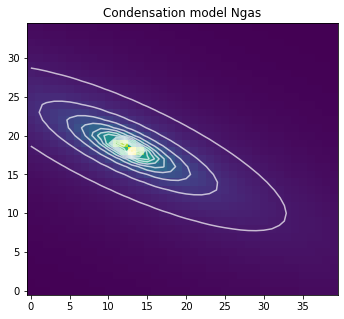

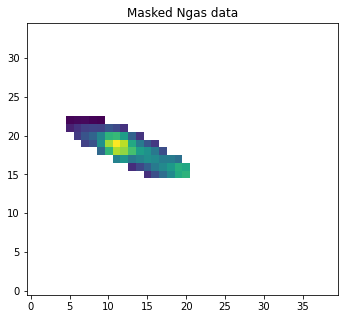

Mean Number density:  5287.951303844742
Median Number density:  5330.983456976902
Angle dispersion =  23.5302489330418
B_bar : 9.147749299430049e-05
Bu =  8.017349476870966e-06
B0 =  0.00019991881266214403
Contrast Ratio =  123.51861266352563


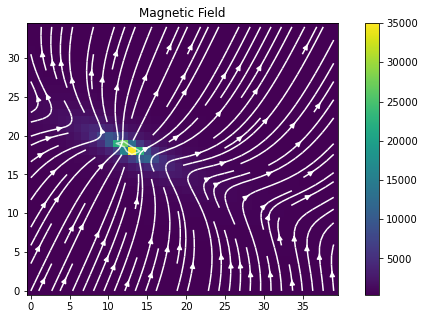

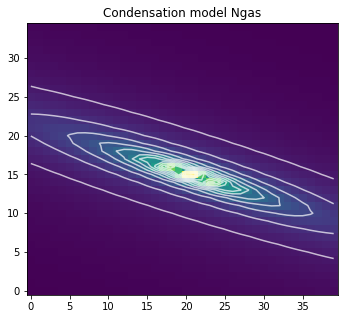

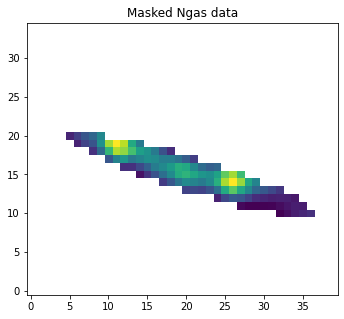

Mean Number density:  4820.640072864804
Median Number density:  4709.668202853055
Angle dispersion =  21.5583258076284
B_bar : 0.00010751370044643759
Bu =  1.4760546793065459e-05
B0 =  0.00024049775490644456
Contrast Ratio =  64.76773282533183


/tmp/ipykernel_517/2315273324.py:265: UserWarning: No contour levels were found within the data range.
  plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)


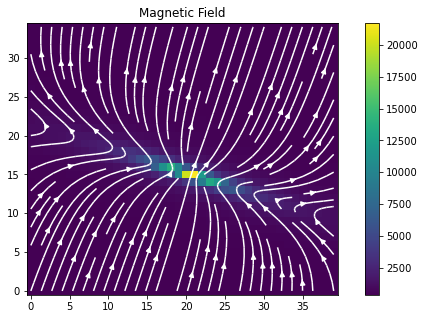

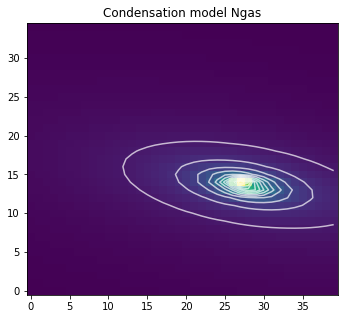

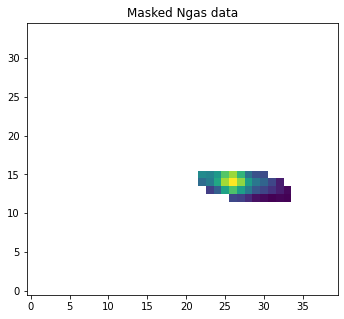

Mean Number density:  5410.129827733116
Median Number density:  5189.634636450907
Angle dispersion =  15.823995884657812
B_bar : 0.00015813298741967013
Bu =  1.277484183734428e-05
B0 =  0.0004423353715624381
Contrast Ratio =  202.74839958094762


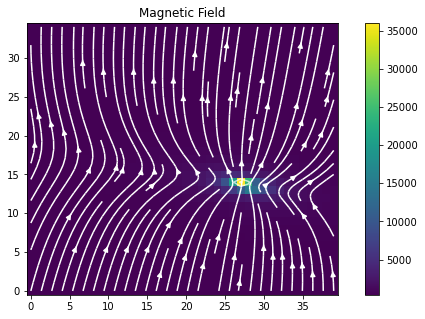

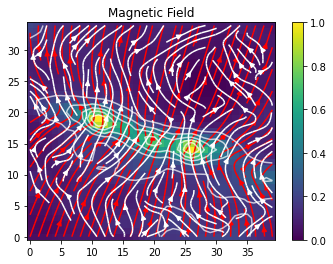

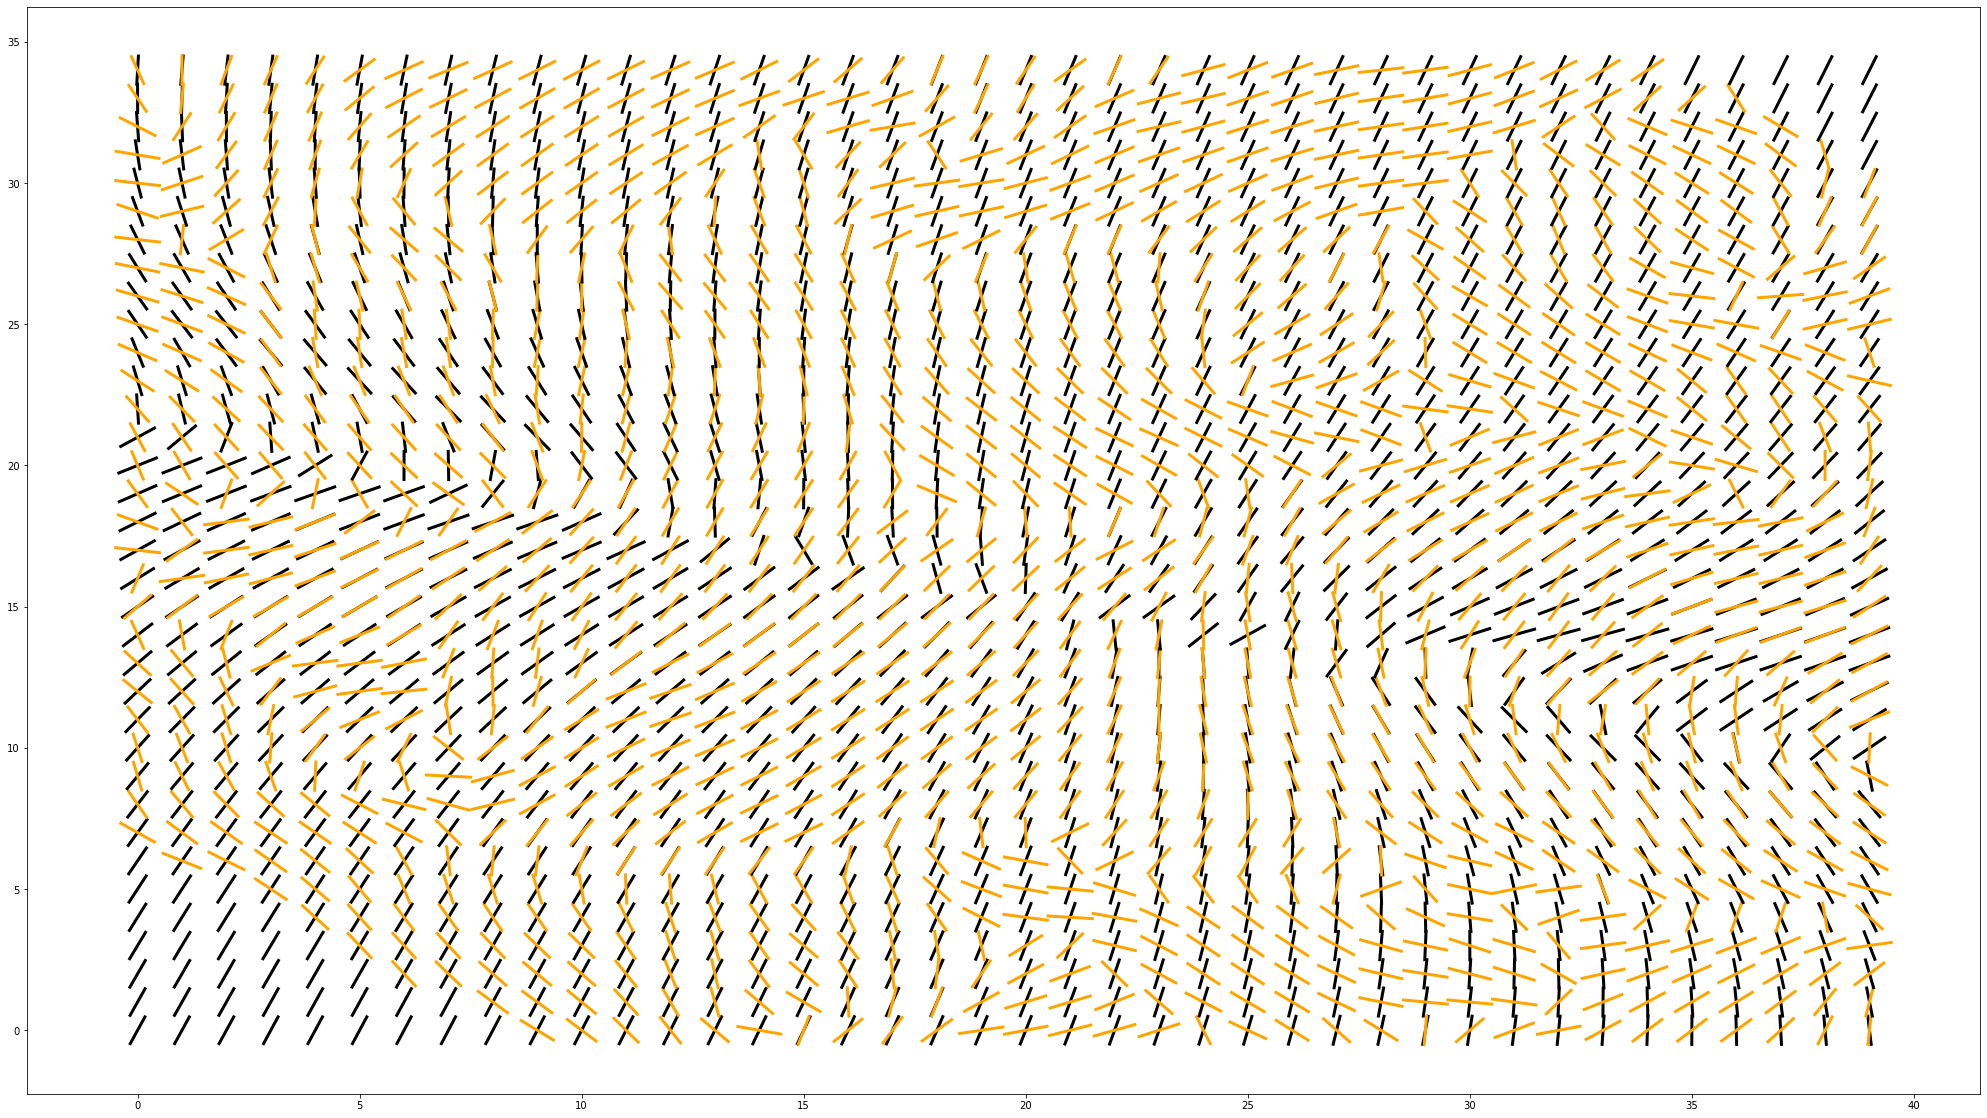

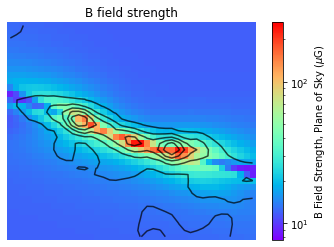

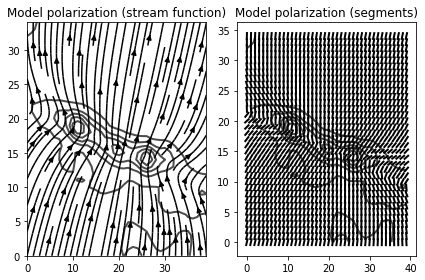

In [16]:
#Things to add to this section: more details on general description, choice to have different methods for dcf estimate, one is find mass using area within
# contour, use the model density itself or use the cylindrical bone method

'''
This section is where we estimate the magnetic field strength on a pixel by pixel basis based on the best fit SFF model.
Most of the hard work is now behind us and we just have to think about how we want to do 
'''

#Most of this section does not require user input so scroll down until the next section marker --------------------------------------------------------

#Defining the density contrast ratio between the peak density and background density for each condensation 
v01 = n01/nu
v02 = n02/nu
v03 = n03/nu

#Setting a number of functions to do the DCF estimate

def lowest_stddev(input_array):
    '''
    This function accurately calculates the angle dispersion within the inputed array. 
    
    The only input is the array containing the data where the angles are in degrees. 
    
    The function outputs the appropriate angle dispersion and the median angle.
    '''
    #delete nan's and unravel
    input_array = np.ravel(input_array)
    nonans = input_array[~np.isnan(input_array)]
    #add 180
    nonans_p180 = [i+180 if i < 0 else i for i in nonans]  
    min_std = np.min([np.std(nonans),np.std(nonans_p180)])
    if np.std(nonans) < np.std(nonans_p180):
        best_median = np.median(nonans)
    else:
        best_median = np.median(nonans_p180)
    return min_std,best_median

def single_1(mesh):
    '''
    This funtion takes an empty mesh and calculates the density profile of the first condensation on that mesh
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            mesh[y,x] = nu+(n01/frac_1)
    return np.array(mesh)
def single_2(mesh):
    '''
    This funtion takes an empty mesh and calculates the density profile of the second condensation on that mesh
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            mesh[y,x] = nu+(n02/frac_2)
    return np.array(mesh)
def single_3(mesh):
    '''
    This funtion takes an empty mesh and calculates the density profile of the third condensation on that mesh
    '''
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            mesh[y,x] = nu+(n03/frac_3)
    return np.array(mesh)

def sigle_1_Ngas(mesh,n_0_1, r_0_1, n_u, A_1, theta_1, xcentre_1, ycentre_1):
    '''
    This funtion takes an empty mesh and calculates the column density profile of the first condensation on that mesh
    '''
    z = depth/2
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            mesh[y,x] = part_1
    return np.array(mesh)

def sigle_2_Ngas(mesh, n_0_2, r_0_2, n_u, A_2, theta_2, xcentre_2, ycentre_2):
    '''
    This funtion takes an empty mesh and calculates the column density profile of the second condensation on that mesh
    '''
    z = depth/2
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            mesh[y,x] = part_2
    return np.array(mesh)

def sigle_3_Ngas(mesh,n_0_3, r_0_3, n_u, A_3, theta_3, xcentre_3, ycentre_3):
    '''
    This funtion takes an empty mesh and calculates the column density profile of the third condensation on that mesh
    '''
    z = depth/2
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_3
    return np.array(mesh)

first = single_1(grid)
second = single_2(grid)
third = single_3(grid)
first_Ngas = sigle_1_Ngas(grid, n01, r01, nu, A1, theta1, x1, y1)
second_Ngas = sigle_2_Ngas(grid, n02, r02, nu, A2, theta2, x2, y2)
third_Ngas = sigle_3_Ngas(grid, n03, r03, nu, A3, theta3, x3, y3)

# Next we find how the uniform field has gotten modified for each condensation. We first find the direction fo the 

v_1 = grid.copy() #Doing the same for the normalised density
v_bar_1 = grid.copy() #Doing the same for the normalised mean density within the given normalized radius
B_x_1 = grid.copy() #Doing the same for the x direction of the unit vector representing the modeled field direction
B_y_1 = grid.copy() #Doing the same for the y direction of the unit vector representing the modeled field direction

#We then do the same for each condensation
v_bar_2 = grid.copy()
v_2 = grid.copy()
B_x_2 = grid.copy()
B_y_2 = grid.copy()

v_bar_3 = grid.copy()
v_3 = grid.copy()
B_x_3 = grid.copy()
B_y_3 = grid.copy()

for y in range(len(first)):
    for x in range(len(first[y])):
        #Changing the coordinate frame to be centered at the centre of the condensation
        x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
        y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
        
        w1 = np.sqrt((x_1/(A1*r01))**2+(y_1/r01)**2) #Calculating the normalised radius at the coordinates (see fig 2)
        v_1[y,x] = (1+v01/(1+w1**2)) #Calculating the normalised density at the coordinates (see equ 3)
        v_bar_1[y,x] = (1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1)))  #Calculating the (see equ 4)
        t_1 = v_1[y,x]/v_bar_1[y,x] #Calculating the ratio of density to mean density (see equ 5)
        s_1 = x_1/y_1 #Calculating the ratio of the horizontal and vertical coordinates
        thetaB_1 = np.arctan((1-t_1)/((1/s_1)+(s_1*t_1/(A1**2)))) #Calculating the field direction angle (see equ 19)
        #Calculating the field direction unit vector in the frame of the general map.
        B_x_1[y,x] = np.sin(thetaB_1-theta1) 
        B_y_1[y,x] = np.cos(thetaB_1-theta1)

        #Doing the same thing for the other condensations
        x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
        y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
        w2 = np.sqrt((x_2/(A2*r02))**2+(y_2/r02)**2)
        v_2[y,x] = (1+v02/(1+w2**2))
        v_bar_2[y,x] = (1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        t_2 = v_2[y,x]/v_bar_2[y,x]
        s_2 = x_2/y_2
        thetaB_2 = np.arctan((1-t_2)/((1/s_2)+(s_2*t_2/(A2**2))))
        B_x_2[y,x] = np.sin(thetaB_2-theta2)
        B_y_2[y,x] = np.cos(thetaB_2-theta2)
        
        x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
        y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3) 
        w3 = np.sqrt((x_3/(A3*r03))**2+(y_3/r03)**2)
        v_3[y,x] = (1+v03/(1+w3**2))
        v_bar_3[y,x] = (1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        t_3 = v_3[y,x]/v_bar_3[y,x]
        s_3 = x_3/y_3
        thetaB_3 = np.arctan((1-t_3)/((1/s_3)+(s_3*t_3/(A3**2))))
        B_x_3[y,x] = np.sin(thetaB_3-theta3)
        B_y_3[y,x] = np.cos(thetaB_3-theta3)

Bu_list  = []
def B_estimate_core(Density_model, Ngas_model, cont_level, Continue, B_x, B_y, v_arr, v_bar_arr, v0, Velocity_dispersion_data,B_angle_data, Ngas_data,\
                    Box_height):
    '''
    This function finds the magnetic field strength at every pixel on the map given a specific modeled condensation. As is described in the paper, 
    we first select a region of constant normalised radius (this is simply a contour). When selecting the region we need to make sure that it is large
    enough to encompas the majority of the condensation but is small enough to not be impacted by neighbouring condensations. The function first shows 
    a map of the model with the proposed contours you can choose from as well as a cutout of the column density data within the selected contour.
    We then calculate the mean magnetic field stregth using the standard DCF technique within that contour. We use that mean field strgeth and the mean
    modeled density within the contour to calculate the peak and background B-fields. This is then used to calculate the field strngth over the entire 
    map.
    
    Inputs:
    A modeled density profile array (Density_model) and its corresponding column density profile array (Ngas_model). The contour chosen to do the
    DCF analysis (cont_level) where 0 is the smallest contour and 14 is the smallest contour. Whether or not to estimate the field stength by setting
    Coninue = True if yes and False if not. The mangetic field direction unit vectors array (B_x and B_y). The normalised density array (v_arr). 
    The contained mean normalised density array (v_bar_arr). The contrast ratio (v0), the velocity dispersion data array (Velocity_dispersion_data). The 
    B-field angle data array (B_angle_data). The column density data array (Ngas_data). The determined width of the contour in pixels (Box_height).
    
    The function outputs a vector map of the magnetic field with the appropriate direction and magnitude.
    
    How to use the function appropriately:
    Start with Continue = False, cont_level = 0 and Box_height = 0 and run the function. After the first run, choose an appropriate contour level and 
    re-run the function. Then check by eye how thick the contour is in pixels and edit Box_height to that number. Once happy with everything set 
    Continue = True.
    '''    
    
    #Plotting the column density model of the condensation
    Ngas_model_contour_levels = np.arange(np.nanmin(Ngas_model), np.nanmax(Ngas_model), (np.nanmax(Ngas_model)-np.nanmin(Ngas_model))/15)
    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_model, origin='lower')
    plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.title('Condensation model Ngas')
    plt.show()

    #Making a mask that cuts out data outside of a given contour
    emptymap = np.copy(Density_model)
    emptymap[:] = np.nan
    mask = emptymap.copy()
    for i in range(np.shape(Density_model)[0]):
        for j in range(np.shape(Density_model)[1]):
            if Ngas_model_contour_levels[cont_level] <= Ngas_model[i,j]: # and not np.isnan(widths_cut[i,j])
                mask[i,j] = 1
            else:
                mask[i,j] = np.nan
                
    #Applying the mask to the arrays
    B_angle_data_crop = B_angle_data*mask
    Velocity_dispersion_data_crop = mask*Velocity_dispersion_data
    v_bar_crop = v_bar_arr*mask
    Ngas_data_crop = Ngas_data*mask
    
    #Plotting the masked column density data
    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_data_crop, origin='lower')
    plt.title('Masked Ngas data')
    plt.show()
    
    if Continue:
        #Setting some constants
        box_height_cm = Box_height*pixel_size_arcsec*distance*cm_in_au
        z = box_height_cm/2
        #Calculating necessary compononts for the DCF estimate
        ave_column = np.nanmean(Ngas_data_crop)
        median_column = np.nanmedian(Ngas_data_crop)
        number_density = ave_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2)))
        sig_PA,median_PA = lowest_stddev(B_angle_data_crop)

        print('Mean Number density: ', number_density)
        print('Median Number density: ', median_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2))))
        print('Angle dispersion = ', sig_PA)
        
        #Calculating the mean field strencgth within the area
        B_bar = 0.5*np.sqrt(4*np.pi*number_density*mu_times_mp)*np.nanmean(Velocity_dispersion_data_crop)*100000/np.radians(sig_PA)
        Bu = B_bar/np.nanmin(v_bar_crop) #Calculating the background field strength (see equ 29)
        Bu_list.append(Bu)
        print('B_bar :', B_bar)
        print('Bu = ', Bu)
        print('B0 = ', Bu*(1+v0)**(2/3)) #peak field stength (see equ 31)
        print('Contrast Ratio = ', v0)
        B = Bu*v_arr*(v_bar_arr)**(-1/3) #Calculating the field stength at every pixel (see equ 30)
        
        #Plotting the modeled density as well as the field morphology
        Density_model_contour_levels = np.arange(np.nanmin(Ngas_model), np.nanmax(Ngas_model), (np.nanmax(Ngas_model)-np.nanmin(Ngas_model))/4)
        plt.figure(figsize=(10, 5))
        plt.imshow(Density_model, origin='lower')
        plt.colorbar()
        plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
        plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color= 'w')
        plt.title('Magnetic Field')
        plt.show()
        return (B_x*B, B_y*B)

    
    else:
        return (0,0)

#This is the section that requiers user input -------------------------------------------------------------------------------------------------

#We calculate the magntic field streghths and morphologies associated with each condensation
(B_x_1, B_y_1) = B_estimate_core(Density_model=first, Ngas_model=first_Ngas, cont_level=3, Continue=True, B_x=B_x_1, B_y=B_y_1,\
                                 v_arr=v_1, v_bar_arr=v_bar_1, v0=v01, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

(B_x_2, B_y_2) = B_estimate_core(Density_model=second, Ngas_model=second_Ngas, cont_level=3, Continue=True, B_x=B_x_2, B_y=B_y_2,\
                                 v_arr=v_2, v_bar_arr=v_bar_2, v0=v02, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=2)

(B_x_3, B_y_3) = B_estimate_core(Density_model=third, Ngas_model=third_Ngas, cont_level=3, Continue=True, B_x=B_x_3, B_y=B_y_3,\
                                 v_arr=v_3, v_bar_arr=v_bar_3, v0=v03, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

#--------------------------------------------------------------------------------------------------------------------------------------------

#We do a vector addition of the maps we obtianed in order to find the true field morphology of the system. Each condensation model has its own 
#background field strength so we need to retract 2*Bu from the amplitude
B_x = B_x_1+B_x_2+B_x_3
B_y = B_y_1+B_y_2+B_y_3
amp = np.sqrt(B_y**2+B_x**2)-2*np.average(Bu_list)

#ploting the streamline version of the final model and the data on top of one another
plt.imshow(data, origin='lower')
plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color='red')
plt.title('Magnetic Field')
plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='white')
plt.colorbar()
#plt.savefig('Model_vs_dat_streamline.pdf')
plt.show()

#Doing the same thing but with the segment vectors, Remember we can change the step and size of the vectors by changing step and scale bllow
model_angle = np.arctan(-B_x/B_y)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=model_angle.shape
dlist=[]
list_m=[] # model vector display info
list_r=[] # data vector display info

step=1
scale=step
plt.figure(figsize=(35, 20))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])
        
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        
        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=3)
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'orange',  linewidth=3) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#plt.savefig('Model_vs_dat_segments.pdf')
plt.show()

#plotting the B-field strength map
plt.title('B field strength')
plt.imshow(amp*1e6,origin = 'lower',norm=colors.LogNorm(vmin=np.min(amp)*0.9*1e6, vmax=np.max(amp)*1.1*1e6), cmap = 'rainbow')
plt.colorbar(label = 'B Field Strength, Plane of Sky ($\mu$G)')
plt.contour(data, levels=contour_levels, colors = 'k', alpha = 0.7)
plt.axis('off')
#plt.savefig('model_B_strength.pdf')
plt.show()

#plotting the model polarisation
plt.subplot(1,2,1)
plt.streamplot(xarr,yarr,B_x,B_y, density=1, linewidth=None, color='k')
plt.contour(data, levels=contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.title('Model polarization (stream function)')

plt.subplot(1,2,2)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=data_angle.shape
step=1
scale=step
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])

        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=2) 
plt.title('Model polarization (segments)')
plt.contour(data, levels=contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.tight_layout()
#plt.savefig('model_polarization.pdf')
plt.show()

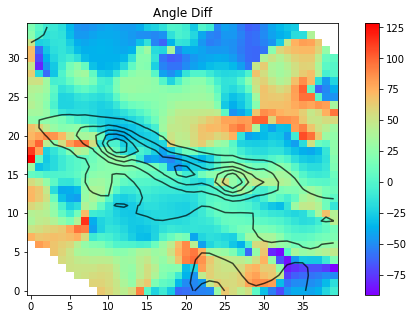

mu =  8.636607334221626 , $\sigma$ =  39.354793975402465
median =  5.190388215651719


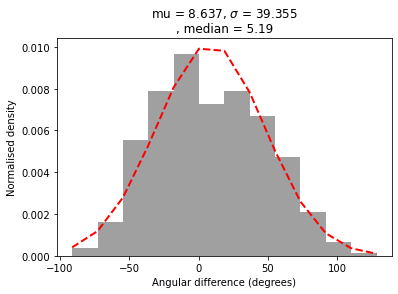

In [17]:
'''
This section calculates the difference between the model field direction and the observed field direction for each pixel and shows the results
'''
#Calculating the difference between the direction angles
ang_dif =  BAngle_data_cut - np.degrees(np.arctan(-B_x/B_y))
#Plotting a map of the difference
plt.figure(figsize=(10, 5))
plt.imshow(ang_dif, origin='lower', cmap = 'rainbow')
plt.colorbar()
plt.title('Angle Diff')
plt.contour(data, levels=contour_levels, colors = 'k', alpha = 0.7)
plt.show()

#Turning the 2-D map into a 1-D array without 'nan' values
ang_dif_1d = np.ravel(ang_dif)
ang_dif_clean = list()
for element in ang_dif_1d:
    if not np.isnan(element):
        ang_dif_clean.append(element)
#Finding the average difference and the dispersion of the difference
mu = np.nanmean(ang_dif_clean)
sigma = np.nanstd(ang_dif_clean)

#Plot the histogram of the data
n, bins, patches = plt.hist(ang_dif_clean, 12,density=True,  facecolor='grey', alpha=0.75)
print('mu = ', mu, ', $\sigma$ = ', sigma)
print('median = ', np.median(ang_dif_clean))
title = 'mu = '+ str(np.around(mu,3))+ ', $\sigma$ = '+ str(np.around(sigma,3)) + '\n, median = ' + str(np.around(np.median(ang_dif_clean),3))
# add a 'best fit' line
y = norm.pdf( bins, mu, sigma) 
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Angular difference (degrees)')
plt.ylabel('Normalised density')
plt.title(title)
#plt.savefig('Angle_differences.pdf')
plt.show()